In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## **Upload Datasets**

*Combine train and test data to avoid data leakage*

In [ ]:
df_train=pd.read_csv('Datasets/train.csv')
df_test=pd.read_csv('Datasets/test.csv')

In [3]:
df_train.shape,df_test.shape

((1460, 81), (1459, 80))

In [4]:
df = pd.concat([df_train, df_test], ignore_index=True)

In [5]:
df.shape

(2919, 81)

## **Exploratory Data Analysis (EDA)**

*Use Heatmap for check null values*

<Axes: >

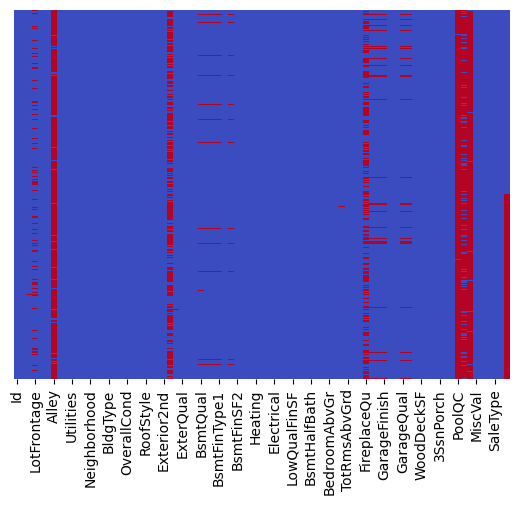

In [6]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')

## **Handling Missing Values**

In [7]:
 # Drop columns with more than 80% missing values
cols_to_drop = [col for col in df.columns if df[col].isnull().sum() > (0.8 * len(df))]
df.drop(columns=cols_to_drop, inplace=True)
print(f"Dropped columns with > 80% missing values: {cols_to_drop}")

 # Impute missing numerical values with the mean
num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].apply(lambda col: col.fillna(col.mean()))

# Impute missing categorical values with the mode
obj_cols = df.select_dtypes(include=['object']).columns
df[obj_cols] = df[obj_cols].apply(lambda col: col.fillna(col.mode()[0]))


Dropped columns with > 80% missing values: ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


<Axes: >

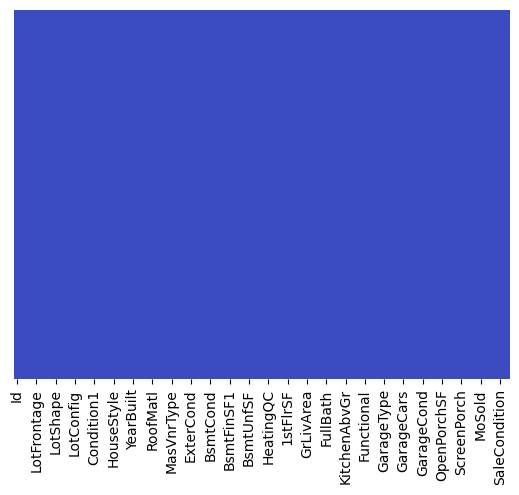

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm')

 ### Observation: *Now data has no missing value and we drop columns which has more than 80% missing values*

## Feature Engineering

In [9]:

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Correlation with Target
if 'SalePrice' in correlation_matrix.columns:
    target_correlation = correlation_matrix['SalePrice'].sort_values(ascending=False)
    print(target_correlation)
else:
    print("Column 'SalePrice' is not in the correlation matrix.")


SalePrice        1.000000
OverallQual      0.548617
GrLivArea        0.520311
GarageCars       0.444406
GarageArea       0.437654
TotalBsmtSF      0.431912
1stFlrSF         0.422097
FullBath         0.394977
TotRmsAbvGrd     0.390869
YearBuilt        0.368664
YearRemodAdd     0.354302
MasVnrArea       0.339679
Fireplaces       0.329421
GarageYrBlt      0.321398
BsmtFinSF1       0.273579
LotFrontage      0.244680
LotArea          0.236105
2ndFlrSF         0.229926
WoodDeckSF       0.227241
OpenPorchSF      0.218983
HalfBath         0.200900
BsmtFullBath     0.158871
BsmtUnfSF        0.152487
BedroomAbvGr     0.117945
ScreenPorch      0.078206
PoolArea         0.073608
3SsnPorch        0.036693
MoSold           0.032698
BsmtFinSF2      -0.007672
Id              -0.007753
BsmtHalfBath    -0.011578
MiscVal         -0.013101
LowQualFinSF    -0.018975
YrSold          -0.020656
OverallCond     -0.055036
MSSubClass      -0.059294
EnclosedPorch   -0.086496
KitchenAbvGr    -0.098734
Name: SalePr

In [10]:
df['TotalBathroom'] = df['FullBath'] + (df['HalfBath'] * 0.5)
df['TotalBsmtBath'] = df['BsmtFullBath'] + (df['BsmtHalfBath'] * 0.5)

df.drop(['Id', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

# Drop columns with low correlation or unnecessary features
cols_to_drop = ['3SsnPorch', 'BsmtFinSF2', 'MiscVal', 'LowQualFinSF', 'KitchenAbvGr', 'EnclosedPorch', 
                'MSSubClass', 'ScreenPorch', 'BedroomAbvGr']
df.drop(columns=cols_to_drop, inplace=True)

## **Train and Test Data**

In [11]:
Y_train=df_train['SalePrice']

In [ ]:
Y_test=pd.read_csv('sample_submission.csv')
Y_test=Y_test['SalePrice']

In [13]:
Y_train = pd.concat([Y_train, Y_test], axis=0).reset_index(drop=True)

In [14]:
X_train=df.drop(['SalePrice'],axis=1)

In [15]:
X_test= X_train.iloc[1460:2920] 

### **Preprocessor / Column Transformer**

In [16]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

## **Models**

In [17]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

In [18]:
xgboost_model = XGBRegressor(n_estimators=1000, learning_rate=0.001, max_depth=8, reg_lambda=5)
lightgbm_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.001, max_depth=8, reg_lambda=5)
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.001, depth=8, l2_leaf_reg=5)
randomForest_model = RandomForestRegressor(n_estimators=500, max_depth=8,criterion='squared_error',min_samples_split=10, min_samples_leaf=2,random_state=42)

## **Pipeline**

In [19]:
from sklearn.pipeline import Pipeline 

In [20]:
xgboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost_model)
])
lightgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lightgbm_model)
])
catboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', catboost_model)
])
randomforest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', randomForest_model)
])

## **Voting Regressor**


In [21]:
from sklearn.ensemble import VotingRegressor

In [22]:
voting_regressor = VotingRegressor(estimators=[
    ('xgb', xgboost_pipeline),
    ('lgb', lightgbm_pipeline),
    ('catboost', catboost_pipeline),
    ('randomforest', randomforest_pipeline)
])

In [23]:
voting_regressor.fit(X_train, Y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3521
[LightGBM] [Info] Number of data points in the train set: 2919, number of used features: 198
[LightGBM] [Info] Start training from score 180052.854627
0:	learn: 57349.7789354	total: 71.3ms	remaining: 1m 11s
1:	learn: 57329.1876702	total: 82.2ms	remaining: 41s
2:	learn: 57307.0888478	total: 93ms	remaining: 30.9s
3:	learn: 57288.0704220	total: 104ms	remaining: 25.9s
4:	learn: 57266.7119976	total: 115ms	remaining: 22.8s
5:	learn: 57246.2939488	total: 126ms	remaining: 20.8s
6:	le

VotingRegressor(estimators=[('xgb',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars',...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                                             ('model',
                                              RandomForestRegressor(max_depth=8,
                                                                    min_samples_leaf=2,
                                                                    min_samples_split=10,
                                                                    n_estimators=500,
                                                                    random_state=42))]))])

## **Predictions**

In [24]:
prediction=voting_regressor.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [25]:
prediction

array([162763.57013707, 175072.83578556, 182210.83285416, ...,
       181199.32269983, 157832.61343935, 200080.15850257])

In [26]:
from sklearn.metrics import mean_squared_log_error
def RMSE(trueValue,predictedValue):
    mse=mean_squared_log_error(trueValue,predictedValue)
    rmse=np.sqrt(mse)
    return rmse

In [27]:
test_rmse = RMSE(Y_test,prediction)

print(test_rmse)

0.0969372436861084


In [28]:
log_test_rmse= RMSE(np.log1p(Y_test), np.log1p(prediction))

print(log_test_rmse)

0.0073892372108106865


## **Submission**

In [ ]:
# Load the existing submission file
submission_file = "Datasets/sample_submission.csv"  # Replace with your submission file path
submission = pd.read_csv(submission_file)

# Check if a previous prediction column exists and drop it
old_prediction_column = "SalePrice"  # Replace with the name of your old prediction column, if any
if old_prediction_column in submission.columns:
    submission = submission.drop(columns=[old_prediction_column])

# Append the new predictions column
   # Replace with your new predictions
submission["SalePrice"] = prediction

# Save the updated submission file
submission.to_csv("Submission/submission.csv", index=False)

print("Updated submission file created: 'submission.csv'") 

Updated submission file created: 'submission.csv'


In [ ]:
import pickle
pickle.dump(voting_regressor,open('Model/model.pkl','wb'))